In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from IPython.display import clear_output
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from models import Encoder, Decoder, NeuroDataset
from itertools import combinations
from utils import calc_gradient_magnitude
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from IPython.core.debugger import set_trace

In [2]:
embedding = np.load('./embeddings/AE1024_dim-36_ep-500_denoise-1e-2_MSE.npy')
embedding = torch.from_numpy(embedding).float().cuda()

# Latent model

In [3]:
class NueroLSTM(nn.Module):
    
    def __init__(self, 
                 input_size, 
                 out_size, 
                 hidden_size, 
                 num_layers, 
                 use_attention=False, 
                 dropout=0., 
                 dt=None, 
                 add_1dconv=False, 
                 dim_1dconv=64,
                 kernel_size=5,
                 dilation=1,
                 separate_lstm_per_dim=False):
        
        super().__init__()
        self.input_size = input_size
        self.out_size = out_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_attention = use_attention
        self.dropout = dropout
        self.dt = dt
        self.add_1dconv = add_1dconv
        self.dim_1dconv = dim_1dconv
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.separate_lstm_per_dim = separate_lstm_per_dim 
        if separate_lstm_per_dim:
            self.lstm = nn.ModuleList([nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout) \
                                       for i in range(self.out_size)])
            self.linear_hidden2one = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU())\
                                                   for i in range(self.out_size)])
        else:
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        if self.add_1dconv:
            linear_in_size = hidden_size + dim_1dconv
        elif self.separate_lstm_per_dim:
            linear_in_size = out_size
        else:
            linear_in_size = hidden_size
        
        self.linear = nn.Linear(linear_in_size, out_size)
        
        
        if self.add_1dconv:
            kernel_size = self.kernel_size
            dilation = self.dilation
            kernel_size_eff = kernel_size + (kernel_size-1)*(dilation-1)
            conv_layers = []
            current_dim = self.dt
            in_planes = input_size
            while current_dim > 1:
                if current_dim <= kernel_size_eff:
                    kernel_size = current_dim
                    dilation = 1
                    padding = 0
                    maxpool = False
                    current_dim = 1
                else:
                    padding = kernel_size_eff//2 
                    current_dim = current_dim//2
                    maxpool = True
                conv_layers.append(nn.BatchNorm1d(in_planes))
                conv_layers.append(nn.Conv1d(in_planes, dim_1dconv, kernel_size, padding=padding, dilation=dilation))
                if maxpool:
                    conv_layers.append(nn.MaxPool1d(2,2))
                conv_layers.append(nn.LeakyReLU())
                in_planes = dim_1dconv
                
            conv_layers.append(nn.Conv1d(dim_1dconv, dim_1dconv, 1))    
            self.conv1d_block = nn.Sequential(*conv_layers)
            self.last_bn = nn.BatchNorm1d(dim_1dconv + hidden_size)
            
    
    def forward(self, sequence):
        if self.separate_lstm_per_dim:
            out = []
            for lstm, linear in zip(self.lstm, self.linear_hidden2one):
                out_l, _ = lstm(sequence)
                out_l = linear(out_l[:,-1])
                out.append(out_l)
            out = torch.cat(out, -1)
        else:
            out, _ = self.lstm(sequence)
            out = out[:,-1]
        
        if self.add_1dconv:
            out_cnn = self.conv1d_block(sequence.transpose(2,1)).squeeze(-1)
            out = torch.cat([out, out_cnn],1)
            out = self.last_bn(out)
            
        out = self.linear(out)
        return out

In [4]:
class SequentialDataloader(Dataset):
    '''
    Returns sequential  
    '''
    def __init__(self, data, target=None, dt=10, dt_target=1):
        
        super().__init__()
        self.dt = dt
        self.dt_target = dt_target
        self.target = target
        self.use_target = target is not None
        if not isinstance(data, torch.Tensor):
            self.data_tensor = torch.from_numpy(data)
        else:
            self.data_tensor = data
        
    def __getitem__(self,i):
        data = self.data_tensor[i:i+self.dt]
        if self.use_target:
            target = self.target[i+self.dt]
        else:
            target = self.data_tensor[i+self.dt:i+self.dt+self.dt_target]
        return data, target

    def __len__(self):
        return self.data_tensor.shape[0] - self.dt - self.dt_target

In [5]:
def seq_n_step_predict(model, initial_seq, n_steps_predict):
    results = []
    seq = initial_seq
    for i in range(n_steps_predict):
        out = model(seq)
        results.append(out)
        seq = torch.cat([seq[:,1:],out.unsqueeze(1)], dim=1)
    return torch.stack(results, 1)

In [6]:
def validate(model, val_loader, criterion, n_steps_predict_loss):
    model.eval()
    history = defaultdict(list)
    with torch.no_grad():
        for itr, (seq, target) in enumerate(val_loader):  
            
            out = seq_n_step_predict(nlstm, seq, n_steps_predict_loss)
            mae = torch.norm(out - target, dim=-1, p=1)
            loss = (mae.mean(0) * time_weights).mean()
            
            MAE = torch.norm(out - target, p=1, dim=-1) / torch.norm(target, p=1, dim=-1)
            MAE = MAE.mean()
            
            history['total_loss'].append(loss.item())
            history['MAE'].append(MAE.item())
    
    history = {k:np.mean(v) for k,v in history.items()}
    return history

# Regression embedding

In [7]:
dt = 200
plot=True
clip_grads= False
n_steps_predict = 300
n_steps_predict_loss = 5
epochs = 1000
batch_size = 96
criterion = nn.MSELoss()

In [8]:
N, code_dim = embedding.shape
train_ratio = 0.9
split_index = int(train_ratio*N)

embedding_train = embedding[:split_index]
embedding_val = embedding[split_index:]   

dataset_seq_train = SequentialDataloader(embedding_train, dt=dt, dt_target=n_steps_predict_loss)
dataloader_seq_train = DataLoader(dataset_seq_train, batch_size=batch_size, shuffle=True)

dataset_seq_val = SequentialDataloader(embedding_val, dt=dt, dt_target=n_steps_predict_loss)
dataloader_seq_val = DataLoader(dataset_seq_val, batch_size=batch_size, shuffle=False)

time_weights = torch.ones(n_steps_predict_loss).cuda()

In [9]:
embedding_train.shape, embedding_val.shape

(torch.Size([16807, 36]), torch.Size([1868, 36]))

In [10]:
for seq, target in dataloader_seq_train:
    break
seq.shape, target.shape

(torch.Size([96, 200, 36]), torch.Size([96, 5, 36]))

In [11]:
nlstm = NueroLSTM(code_dim, 
                  code_dim, 
                  hidden_size=64, 
                  num_layers=1, 
                  dropout=0.00, 
                  dt=dt, 
                  add_1dconv=False, 
                  dilation=5,
                  dim_1dconv=64,
                  separate_lstm_per_dim=True).cuda()
optimizer_seq = torch.optim.Adam(nlstm.parameters())

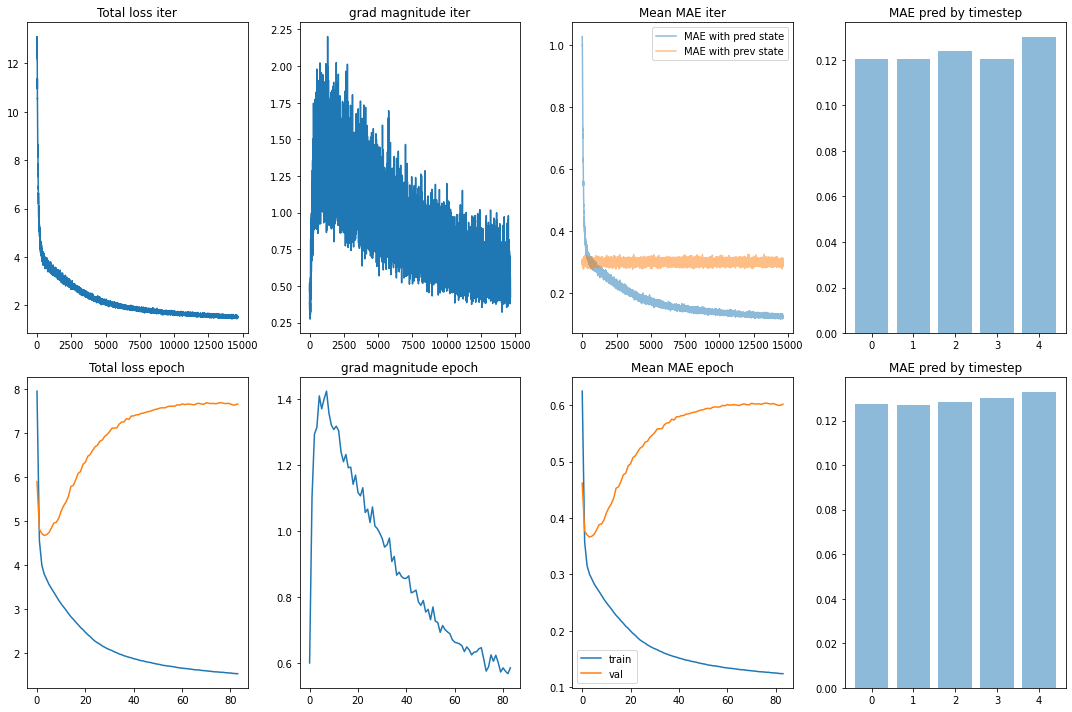

In [ ]:
history_train = defaultdict(list)
history_val = defaultdict(list)

for epoch in range(epochs):
    for itr, (seq, target) in enumerate(dataloader_seq_train): 
        
        nlstm.train()
        optimizer_seq.zero_grad()
        
        seq = seq.cuda()
        target = target.cuda()
        before_target = seq[:,-1,...].detach()
        before_target = before_target.unsqueeze(1).repeat(1,n_steps_predict_loss,1)
        
        with torch.autograd.detect_anomaly():
            out = seq_n_step_predict(nlstm, seq, n_steps_predict_loss)
            mae = torch.norm(out - target, dim=-1, p=1)
            train_loss = (mae.mean(0) * time_weights).mean()
            train_loss.backward()
            
            # metrics
            if clip_grads:
                MAX_GRAD = 1
                torch.nn.utils.clip_grad_value_(nlstm.parameters(), MAX_GRAD)
                assert max([param.grad.abs().max().item() for param in nlstm.parameters()]) <= MAX_GRAD
            
            grad_magnitude = calc_gradient_magnitude(filter(lambda x: x[1].requires_grad, \
                                                                  nlstm.named_parameters()), silence=False)
            
            MAE_norm = mae / torch.norm(target, p=1, dim=-1)
            MAE_norm = MAE_norm.mean(0).detach()
            
            MAE_norm_diff = torch.norm(before_target - target, p=1, dim=-1) / torch.norm(target, p=1, dim=-1)
            MAE_norm_diff = MAE_norm_diff.mean()
            
            # perform parameter update based on current gradients
            optimizer_seq.step()

        history_train['total_loss'].append(train_loss.item())
        history_train['MAE_by_time'].append([MAE_norm[i].item() for i in range(n_steps_predict_loss)])
        history_train['MAE'].append(MAE_norm.mean().item())
        history_train['MAE_diff'].append(MAE_norm_diff.item())
        history_train['grad_magnitude'].append(grad_magnitude)
        
        if (itr%100) == 0:
            clear_output(wait=True)
            fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15,10))
            
            #--------TRAIN
            axes[0,0].plot(history_train['total_loss'])
            axes[0,0].set_title(f'Total loss iter')

            axes[0,1].plot(history_train['grad_magnitude'])
            axes[0,1].set_title(f'grad magnitude iter')
            
            axes[0,2].plot(history_train['MAE'], label=f'MAE with pred state',alpha=0.5)
            axes[0,2].plot(history_train['MAE_diff'], label='MAE with prev state',alpha=0.5)
            axes[0,2].set_title(f'Mean MAE iter')
            axes[0,2].legend()
            
            axes[0,3].bar(range(n_steps_predict_loss),
                          history_train['MAE_by_time'][-1], 
                          label='MAE_by_time_epoch',
                          alpha=0.5)
            axes[0,3].set_title(f'MAE pred by timestep')
            
            #----------EPOCH
            if epoch > 0:
                axes[1,0].plot(history_train['total_loss_epoch'], label='train')
                axes[1,0].plot(history_val['total_loss'], label='val')
                axes[1,0].set_title(f'Total loss epoch')

                axes[1,1].plot(history_train['grad_magnitude_epoch'], label='train')
                axes[1,1].set_title(f'grad magnitude epoch')

                axes[1,2].plot(history_train['MAE_epoch'], label='train')
                axes[1,2].plot(history_val['MAE'], label='val')
                axes[1,2].set_title(f'Mean MAE epoch')
                axes[1,2].legend()


                axes[1,3].bar(range(n_steps_predict_loss),
                              history_train['MAE_by_time_epoch'][-1], 
                              label='MAE_by_time_epoch', 
                              alpha=0.5)
                axes[1,3].set_title(f'MAE pred by timestep')
                plt.tight_layout()
            
            # show discrepancy
            nlstm.eval()
            fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(36,36))
            
            start_index = np.random.choice(np.arange(embedding_val.shape[0] - n_steps_predict - dt))
            initial_seq = embedding_val[start_index:start_index+dt]
            target_seq = embedding_val[start_index+dt:start_index+dt+n_steps_predict].detach().cpu().numpy()
            with torch.no_grad():
                predicted_seq = seq_n_step_predict(nlstm, initial_seq.unsqueeze(0), n_steps_predict)[0].detach().cpu().numpy()
            for i,ax in enumerate(axes.flatten()):
                ax.plot(target_seq[:,i], label='target_seq')
                ax.plot(predicted_seq[:,i], label='predicted_seq')
                ax.legend()
            plt.tight_layout()
            plt.show()


    # END of the epoch
    history_train['total_loss_epoch'].append(np.mean(history_train['total_loss'][-len(dataloader_seq_train):]))
    history_train['MAE_epoch'].append(np.mean(history_train[f'MAE'][-len(dataloader_seq_train):]))
    history_train['MAE_by_time_epoch'].append([np.mean([history_train['MAE_by_time'][-i][t] for i in range(len(dataloader_seq_train))]) \
                                               for t in range(n_steps_predict_loss)]) 
    history_train['grad_magnitude_epoch'].append(np.mean(history_train['grad_magnitude'][-len(dataloader_seq_train):]))    
    
    history_val_item = validate(nlstm, dataloader_seq_val, criterion, n_steps_predict_loss)
    for k,v in history_val_item.items():
        history_val[k].append(v)

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15,10))
            
            #--------TRAIN
            axes[0,0].plot(history_train['total_loss'])
            axes[0,0].set_title(f'Total loss iter')

            axes[0,1].plot(history_train['grad_magnitude'])
            axes[0,1].set_title(f'grad magnitude iter')
            
            axes[0,2].plot(history_train['MAE'], label=f'MAE with pred state',alpha=0.5)
            axes[0,2].plot(history_train['MAE_diff'], label='MAE with prev state',alpha=0.5)
            axes[0,2].set_title(f'Mean MAE iter')
            axes[0,2].legend()
            
            axes[0,3].bar(range(n_steps_predict_loss),
                          history_train['MAE_by_time'][-1], 
                          label='MAE_by_time_epoch',
                          alpha=0.5)
            axes[0,3].set_title(f'MAE pred by timestep')
            
            #----------EPOCH
            if epoch > 0:
                axes[1,0].plot(history_train['total_loss_epoch'], label='train')
                axes[1,0].plot(history_val['total_loss'], label='val')
                axes[1,0].set_title(f'Total loss epoch')

                axes[1,1].plot(history_train['grad_magnitude_epoch'], label='train')
                axes[1,1].set_title(f'grad magnitude epoch')

                axes[1,2].plot(history_train['MAE_epoch'], label='train')
                axes[1,2].plot(history_val['MAE'], label='val')
                axes[1,2].set_title(f'Mean MAE epoch')
                axes[1,2].legend()


                axes[1,3].bar(range(n_steps_predict_loss),
                              history_train['MAE_by_time_epoch'][-1], 
                              label='MAE_by_time_epoch', 
                              alpha=0.5)
                axes[1,3].set_title(f'MAE pred by timestep')
                plt.tight_layout()
            
            # show discrepancy
            nlstm.eval()
            fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(36,36))
            
            start_index = np.random.choice(np.arange(embedding_val.shape[0] - n_steps_predict - dt))
            initial_seq = embedding_val[start_index:start_index+dt]
            target_seq = embedding_val[start_index+dt:start_index+dt+n_steps_predict].detach().cpu().numpy()
            with torch.no_grad():
                predicted_seq = seq_n_step_predict(nlstm, initial_seq.unsqueeze(0), n_steps_predict)[0].detach().cpu().numpy()
            for i,ax in enumerate(axes.flatten()):
                ax.plot(target_seq[:,i], label='target_seq')
                ax.plot(predicted_seq[:,i], label='predicted_seq')
                ax.legend()
            plt.tight_layout()
            plt.show()